In [1]:
%matplotlib notebook

In [2]:
%matplotlib inline

In [3]:
from pathlib import Path
import os
import glob

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle,Circle

import numpy as np
import pandas as pd

from astropy.nddata import CCDData,block_reduce
from astropy.stats import mad_std
from astropy.io import fits
from astropy import units as u
from astropy import visualization as aviz
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs import WCS

import ccdproc as ccdp
from ccdproc import ImageFileCollection

In [4]:
data_path = "../Data"
bias_path = 'bias'
flat_path = 'flat'

In [5]:
binning = "1x1"
# binning = "2x2"
filt = "R"

In [6]:
# define some image edges for the Danish Telescope

if binning=="2x2":
    x1 = 50
    x2 = 22
    y1 = 14

    naxis1 = 1074
    naxis2 = 1032
    
    oscan_x = naxis1-x2
    trim_y2 = naxis1 - x1
    
elif binning=="1x1":
    # lefthand edge of plot
    x1 = 100    
    # righthand edge of plot (overscan?)
    x2 = 45
    # bottom edge of plot
    y1 = 28
    
    # different possible image sizes
    
    naxis1 = 2148
    naxis2 = 2064
    
    # naxis1 = 2148
    # naxis2 = 2048

    # TODO: resize the master flat and bias frames for these values of naxis2
    # or resize the science image by adding some dummy rows/columns?
#     naxis1 = 2148
#     naxis2 = 2044

#     naxis1 = 2148
#     naxis2 = 2040
    
    oscan_x = naxis1-x2
    trim_y2 = naxis1 - x1

    
# ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:,2148-45:], overscan_axis=1, median=True)
# ccd = ccdp.trim_image(ccd[28:2048,x1:]) # do not trim the overscan

# ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:,oscan_x:], overscan_axis=1, median=True)
# ccd = ccdp.trim_image(ccd[y1:trim_y2,x1:]) # do not trim the overscan


In [7]:
print(naxis2,naxis1)
print(naxis2,naxis1 - oscan_x)
print(trim_y2 - y1,naxis1 - x1)

2064 2148
2064 45
2020 2048


In [8]:
master_bias_file = '{}/master_bias_{}_{}_{}.fits'.format(bias_path,filt,binning,naxis1,naxis2)
master_flat_file = '{}/master_flat_{}_{}_{}.fits'.format(flat_path,filt,binning,naxis1,naxis2)

In [9]:
fits_files = glob.glob("{}/**/*.fits".format(data_path), recursive=True)

In [10]:
im_collection=ImageFileCollection(filenames=fits_files)

In [11]:
im_collection

ImageFileCollection(location='', filenames=['../Data/20240601/Flat-R_000002.fits', '../Data/20240601/Flat-R_000003.fits', '../Data/20240601/Asteroid-59259_000001.fits', '../Data/20240601/Bias-1x1_000004.fits', '../Data/20240601/Asteroid-59259_000002.fits', '../Data/20240601/Flat-R_000001.fits', '../Data/20240601/Bias-1x1_000002.fits', '../Data/20240601/Bias-1x1_000003.fits'])

In [12]:
df_fits = im_collection.summary.to_pandas()

In [13]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(df_fits)

In [14]:
df_fits["frame"] = df_fits["file"].str.split("/").str[-1]

In [15]:
np.sort(list(df_fits.columns))

array(['agobjdec', 'agobjra', 'agon', 'aguider_offsdec', 'aguider_offsra',
       'aguider_stop', 'airmass', 'altitude', 'atsp1dec', 'atsp1en',
       'atsp1ra', 'atsp2en', 'atsp2pa', 'atsp2ts', 'average', 'binning',
       'binx', 'biny', 'bitpix', 'bscale', 'bzero', 'cam_filt', 'ccd_ser',
       'ccd_temp', 'ccd_type', 'ccdpsiz', 'ccdsum', 'cdelt1', 'cdelt2',
       'cdsg', 'chan', 'chan1', 'chan2', 'comm_num', 'corr_dec',
       'corr_img', 'corr_ra', 'crota2', 'crpix1', 'crpix2', 'crval1',
       'crval2', 'ctime', 'ctype1', 'ctype2', 'data_channels', 'datasec',
       'date', 'date-obs', 'detsec', 'detsize', 'dtm1_1', 'dtm2_2',
       'dtv1', 'dtv2', 'equinox', 'exposure', 'exptime', 'extend', 'file',
       'filta', 'filtb', 'filter', 'foc_def', 'foc_foff', 'foc_name',
       'foc_pos', 'foc_tar', 'foc_toff', 'foc_type', 'frame', 'gain1',
       'gain2', 'ha', 'history', 'imagetyp', 'instrume', 'jd', 'jd_helio',
       'latitude', 'longitud', 'lst', 'ltm1_1', 'ltm2_2', 'ltv1', 'l

In [16]:
fits_cols = ["frame","date-obs","jd","exptime","filta","filtb","imagetyp",'binning',"binx","biny","naxis1","naxis2"]

In [17]:
df_fits[fits_cols]

,frame,date-obs,jd,exptime,filta,filtb,imagetyp,binning,binx,biny,naxis1,naxis2
0,Flat-R_000002.fits,2024-06-02T10:50:57.260,2.460464e+06,30.000,empty,R,FLAT,1x1,1,1,2148,2064
1,Flat-R_000003.fits,2024-06-02T10:51:59.209,2.460464e+06,30.000,empty,R,FLAT,1x1,1,1,2148,2064
2,Asteroid-59259_000001.fits,2024-06-02T08:21:08.497,2.460464e+06,60.000,empty,R,LIGHT,1x1,1,1,2148,2064
3,Bias-1x1_000004.fits,2024-06-01T22:38:13.869,2.460463e+06,0.002,empty,R,BIAS,1x1,1,1,2148,2064
4,Asteroid-59259_000002.fits,2024-06-02T08:22:37.249,2.460464e+06,60.000,empty,R,LIGHT,1x1,1,1,2148,2064
5,Flat-R_000001.fits,2024-06-02T10:49:53.989,2.460464e+06,30.000,empty,R,FLAT,1x1,1,1,2148,2064
6,Bias-1x1_000002.fits,2024-06-01T22:37:16.377,2.460463e+06,0.002,empty,R,BIAS,1x1,1,1,2148,2064
7,Bias-1x1_000003.fits,2024-06-01T22:37:45.109,2.460463e+06,0.002,empty,R,BIAS,1x1,1,1,2148,2064


In [18]:
df_fits.value_counts("naxis2")

naxis2
2064    8
dtype: int64

In [19]:
df_fits.value_counts("filtb")

filtb
R    8
dtype: int64

In [20]:
# Select the flat (R filter), bias and science images

In [21]:
flat_mask = (df_fits["filtb"]==filt) & (df_fits["binning"]==binning) & (df_fits["imagetyp"]=="FLAT")
bias_mask = (df_fits["binning"]==binning) & (df_fits["imagetyp"]=="BIAS")
sci_mask = (df_fits["filtb"]==filt) & (df_fits["binning"]==binning) & (df_fits["imagetyp"]=="LIGHT")

In [22]:
# ensure images are all the correct size   
flat_mask = flat_mask & (df_fits["naxis1"]==naxis1) & (df_fits["naxis2"]==naxis2)
bias_mask = bias_mask & (df_fits["naxis1"]==naxis1) & (df_fits["naxis2"]==naxis2)
sci_mask = sci_mask & (df_fits["naxis1"]==naxis1) & (df_fits["naxis2"]==naxis2)

In [23]:
df_flat = df_fits[flat_mask]
df_flat[fits_cols]

,frame,date-obs,jd,exptime,filta,filtb,imagetyp,binning,binx,biny,naxis1,naxis2
0,Flat-R_000002.fits,2024-06-02T10:50:57.260,2.460464e+06,30.0,empty,R,FLAT,1x1,1,1,2148,2064
1,Flat-R_000003.fits,2024-06-02T10:51:59.209,2.460464e+06,30.0,empty,R,FLAT,1x1,1,1,2148,2064
5,Flat-R_000001.fits,2024-06-02T10:49:53.989,2.460464e+06,30.0,empty,R,FLAT,1x1,1,1,2148,2064


In [24]:
df_bias = df_fits[bias_mask]
df_bias[fits_cols]

,frame,date-obs,jd,exptime,filta,filtb,imagetyp,binning,binx,biny,naxis1,naxis2
3,Bias-1x1_000004.fits,2024-06-01T22:38:13.869,2.460463e+06,0.002,empty,R,BIAS,1x1,1,1,2148,2064
6,Bias-1x1_000002.fits,2024-06-01T22:37:16.377,2.460463e+06,0.002,empty,R,BIAS,1x1,1,1,2148,2064
7,Bias-1x1_000003.fits,2024-06-01T22:37:45.109,2.460463e+06,0.002,empty,R,BIAS,1x1,1,1,2148,2064


In [25]:
df_sci = df_fits[sci_mask]
df_sci[fits_cols]

,frame,date-obs,jd,exptime,filta,filtb,imagetyp,binning,binx,biny,naxis1,naxis2
2,Asteroid-59259_000001.fits,2024-06-02T08:21:08.497,2.460464e+06,60.0,empty,R,LIGHT,1x1,1,1,2148,2064
4,Asteroid-59259_000002.fits,2024-06-02T08:22:37.249,2.460464e+06,60.0,empty,R,LIGHT,1x1,1,1,2148,2064


In [26]:
np.unique(df_sci["jd"].astype(int))

array([2460463])

In [27]:
np.unique(df_sci["file"].str.split("/Data/").str[-1].str.split("/").str[0])

array(['20240601'], dtype=object)

In [28]:
len(df_flat) + len(df_bias[df_bias["filtb"]=="R"]) + len(df_sci)

8

In [29]:
sci_files = np.array(df_sci["file"])

# Create a master bias frame

analyse the bias frames

create the bias master

In [30]:
bias_files = np.array(df_bias["file"])

bias_hdu_list = []
for f in bias_files:
    hdu = fits.open(f)
    bias_hdu_list.append(hdu)

In [31]:
bias_hdu_list[0].info()

Filename: ../Data/20240601/Bias-1x1_000004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     124   (2148, 2064)   int32 (rescales to uint32)   


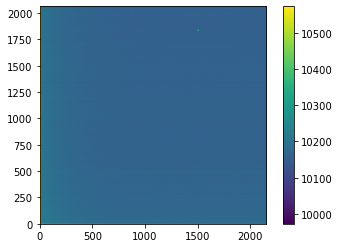

In [32]:
plot_img = bias_hdu_list[0][0].data

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])
fig.add_axes(ax1)

norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
c1 = plt.colorbar(s1)

plt.show()

In [33]:
# check bias values
bias_med = []
bias_std = []

for i,b in enumerate(bias_hdu_list):
#     print(bias_files[i])
    img = b[0].data
#     print(img)

    if img is None:
        print(bias_files[i],img)
        img = np.array([np.nan])
    
    bias_med.append(np.nanmedian(img))
    bias_std.append(np.nanstd(img))
    
bias_med = np.array(bias_med)
bias_std = np.array(bias_std)

In [34]:
img

array([[4294954300,       3195,       8508, ...,      10286,      10428,
             10233],
       [     15139,      11831,      10851, ...,      10219,      10273,
             10075],
       [     15005,      11812,      10744, ...,      10347,      10239,
             10170],
       ...,
       [     15016,      11633,      10732, ...,      10102,      10197,
             10173],
       [     15068,      11681,      10695, ...,      10144,      10227,
             10163],
       [     15049,      11760,      10654, ...,      10226,      10019,
             10145]], dtype=uint32)

In [35]:
bias_med,bias_std

(array([10169., 10182., 10171.]),
 array([2039790.16646384, 2039790.07301153, 2039790.12657356]))

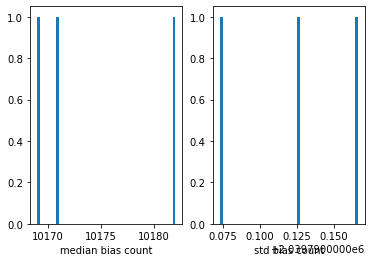

In [36]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

x = ax1.hist(bias_med, bins = 50)
x = ax2.hist(bias_std, bins = 50)

ax1.set_xlabel("median bias count")
ax2.set_xlabel("std bias count")

plt.show()

In [37]:
if binning=="2x2":
    std_mask = bias_std > 5e6    
#     std_mask = bias_std < 4e6    

else:
    std_mask = bias_std > 1e7

for b in np.array(bias_hdu_list)[std_mask]:
    
    plot_img = b[0].data

    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])
    fig.add_axes(ax1)

    norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
    s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
    c1 = plt.colorbar(s1)

    plt.show()
#     break

In [38]:
np.amin(bias_med),np.amax(bias_med)

(10169.0, 10182.0)

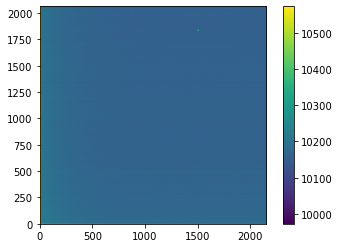

In [39]:
# med_mask = bias_med > 10020
# med_mask = bias_med > 15000
med_mask = bias_med < 15000

for b in np.array(bias_hdu_list)[med_mask]:
    
    plot_img = b[0].data

    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])
    fig.add_axes(ax1)

    norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
    s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
    c1 = plt.colorbar(s1)

    plt.show()
    break

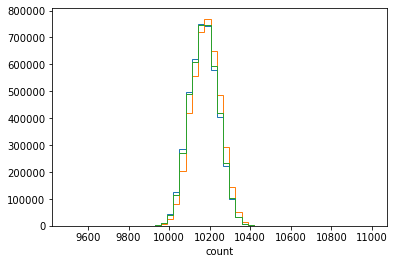

In [40]:
# Histogram of bias file pixel counts

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

bins = np.linspace(9500,11000)
    
for i,b in enumerate(np.array(bias_hdu_list)):
    
    plot_img = b[0].data

    if plot_img is None:
        print(bias_files[i], plot_img)
        continue
        
    x = ax1.hist(plot_img.flatten(), bins = bins, histtype = "step")

ax1.set_xlabel("count")
# ax1.set_yscale("log")
plt.show()

In [41]:
if binning=="2x2":
    good_bias_mask = (bias_std < 5e6) & (bias_std > 3e6) & (bias_files!="../Data/20240607/bias+2x2_000003.fits")
else:
    good_bias_mask = (bias_std < 1e7)

In [42]:
bias_files[good_bias_mask]

array(['../Data/20240601/Bias-1x1_000004.fits',
       '../Data/20240601/Bias-1x1_000002.fits',
       '../Data/20240601/Bias-1x1_000003.fits'], dtype=object)

../Data/20240601/Bias-1x1_000004.fits (2064, 2148) 10169.0 2039790.1664638396


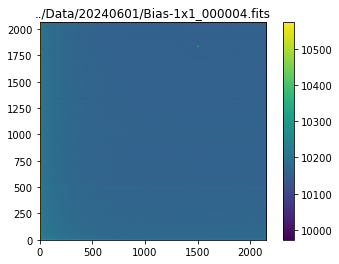

In [43]:
for i,b in enumerate(np.array(bias_hdu_list)[good_bias_mask]):
    
    plot_img = b[0].data
    
    print (bias_files[good_bias_mask][i], np.shape(plot_img), np.median(plot_img),np.std(plot_img))


    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])
    fig.add_axes(ax1)

    norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
    s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
    c1 = plt.colorbar(s1)

    plt.title(bias_files[good_bias_mask][i])
    
    plt.show()
    break

In [44]:
len(bias_files),len(bias_files[good_bias_mask])

(3, 3)

In [45]:
if not os.path.isfile(master_bias_file):

    bias_list = []
    for file in bias_files[good_bias_mask]:
        ccd = CCDData.read(file, unit = u.adu)
        print (file, np.shape(ccd.data), np.median(ccd.data),np.std(ccd.data))
#         ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:,2148-45:], overscan_axis=1, median=True)
#         ccd = ccdp.trim_image(ccd[28:2048,x1:]) # do not trim the overscan
        ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:,oscan_x:], overscan_axis=1, median=True)
        ccd = ccdp.trim_image(ccd[y1:trim_y2,x1:]) # do not trim the overscan
        bias_list.append(ccd)

    master_bias = ccdp.combine(bias_list, method='average',sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3)
    master_bias.write(master_bias_file, overwrite=True)
    print ('master bias', np.shape(master_bias.data), np.median(master_bias.data),np.std(master_bias.data))
    
else:
    # read master bias
    print("load {}".format(master_bias_file))
    master_bias = CCDData.read(master_bias_file, unit = u.adu)

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


../Data/20240601/Bias-1x1_000004.fits (2064, 2148) 10169.0 2039790.1664638396
../Data/20240601/Bias-1x1_000002.fits (2064, 2148) 10182.0 2039790.0730115317
../Data/20240601/Bias-1x1_000003.fits (2064, 2148) 10171.0 2039790.1265735559
master bias (2020, 2048) 2.6666666666666665 43.76784479565304


In [46]:
master_bias.shape

(2020, 2048)

In [47]:
master_bias.data

array([[107.66666667, -17.33333333,  53.66666667, ..., -29.        ,
        -18.66666667,  65.        ],
       [ 10.66666667,  51.        ,  37.        , ..., -36.66666667,
        -15.66666667,  60.33333333],
       [ 57.        ,  55.66666667, -25.        , ...,  54.        ,
        -39.33333333, -36.        ],
       ...,
       [ 73.33333333, -38.        ,  32.66666667, ..., -48.        ,
        -14.        ,  22.66666667],
       [ 20.33333333,   5.66666667,  60.66666667, ...,  16.        ,
         31.66666667, -54.        ],
       [ 67.33333333,  23.33333333,  35.66666667, ..., -25.33333333,
         51.        , -18.        ]])

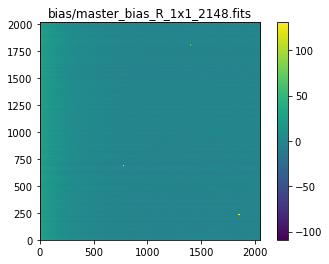

In [48]:
plot_img = master_bias.data

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])
fig.add_axes(ax1)

norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
c1 = plt.colorbar(s1)

plt.title(master_bias_file)

plt.show()

# Create the master flat

In [49]:
flat_files = np.array(df_flat["file"])

flat_hdu_list = []
for f in flat_files:
    hdu = fits.open(f)
    flat_hdu_list.append(hdu)

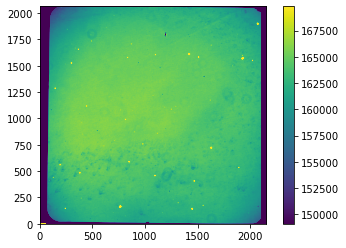

In [50]:
plot_img = flat_hdu_list[0][0].data

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])
fig.add_axes(ax1)

norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
c1 = plt.colorbar(s1)

plt.show()

In [51]:

# check flat values
flat_med = []
flat_std = []

for i,f in enumerate(flat_hdu_list):
    img = f[0].data

    if img is None:
        print(flat_files[i],img)
        img = np.array([np.nan])

    flat_med.append(np.nanmedian(img))
    flat_std.append(np.nanstd(img))

flat_med = np.array(flat_med)
flat_std = np.array(flat_std)
flat_med

array([163441., 185160., 154783.])

In [52]:
good_flat_mask = (flat_std<1.75e7) & (flat_std>1e7)
flat_med[good_flat_mask]

array([163441., 185160., 154783.])

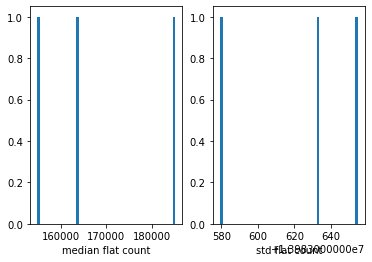

In [53]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

x = ax1.hist(flat_med, bins = 50)
x = ax2.hist(flat_std, bins = 50)
# x = ax1.hist(flat_med[good_flats], bins = 50)
# x = ax2.hist(flat_std[good_flats], bins = 50)

ax1.set_xlabel("median flat count")
ax2.set_xlabel("std flat count")

plt.show()

In [54]:
flat_files[good_flat_mask]

array(['../Data/20240601/Flat-R_000002.fits',
       '../Data/20240601/Flat-R_000003.fits',
       '../Data/20240601/Flat-R_000001.fits'], dtype=object)

In [55]:
if not os.path.isfile(master_flat_file):

    flat_list = []
    scale=[]
    error_list = []

    for file in flat_files[good_flat_mask]:
        ccd = CCDData.read(file, unit = u.adu)
        print (file, np.shape(ccd.data), np.median(ccd.data),np.std(ccd.data))
#         ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:,2148-45:], overscan_axis=1, median=True)
#     #     ccd = ccdp.trim_image(ccd[28:2048,x1:2148-50]) # trim the overscan
#         ccd = ccdp.trim_image(ccd[28:2048,x1:]) # do not trim the overscan
        ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:,oscan_x:], overscan_axis=1, median=True)
        ccd = ccdp.trim_image(ccd[y1:trim_y2,x1:]) # do not trim the overscan

        try:
            ccd = ccdp.subtract_bias(ccd, master_bias)
        except:
            error_list.append(file)
            continue

    #     scale.append(1.0/np.median(ccd[1500:2500,500:1500]))
        scale.append(1.0/np.median(ccd[2148-500:2148+500,2048-500:2048+500]))
        flat_list.append(ccd)

    master_flat = ccdp.combine(flat_list, scale=scale, method='median',sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3)
    master_flat.write(master_flat_file, overwrite=True)
    
else:
    # read master flat
    print("load {}".format(master_flat_file))
    master_flat = CCDData.read(master_flat_file)


a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
/Users/jrobinson/miniconda3/envs/img_red/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
/Users/jrobinson/miniconda3/envs/img_red/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


../Data/20240601/Flat-R_000002.fits (2064, 2148) 163441.0 13983632.841743356
../Data/20240601/Flat-R_000003.fits (2064, 2148) 185160.0 13983579.117381299
../Data/20240601/Flat-R_000001.fits (2064, 2148) 154783.0 13983654.800580965


/Users/jrobinson/miniconda3/envs/img_red/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [56]:
# print(error_list)
# print(len(error_list))
# print(len(flat_files))

(2020, 2048)


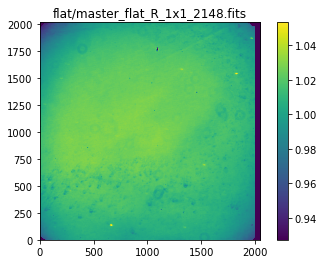

In [57]:
plot_img = master_flat.data
# plot_img = block_reduce(master_flat,2).data

print(plot_img.shape)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])
fig.add_axes(ax1)

norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
c1 = plt.colorbar(s1)

plt.title(master_flat_file)

plt.show()

# reduce images with master flat and bias

In [58]:
len(np.array(df_sci["file"]))

2

In [59]:
np.sort(np.array(df_sci["file"]))

array(['../Data/20240601/Asteroid-59259_000001.fits',
       '../Data/20240601/Asteroid-59259_000002.fits'], dtype=object)

In [60]:
master_flat.shape,master_bias.shape

((2020, 2048), (2020, 2048))

../Data/20240601/Asteroid-59259_000001.fits (2064, 2148)


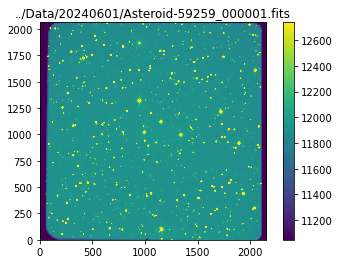

In [61]:
for i,f in enumerate(sci_files):
        
    hdu = fits.open(f)
    plot_img = hdu[0].data
    print(f,plot_img.shape)
    
    if plot_img is None:
        continue
    
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])
    fig.add_axes(ax1)

    norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
    s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
    c1 = plt.colorbar(s1)

    plt.title(f)

    plt.show()
    
    break

In [62]:
# read master flat
master_flat = CCDData.read(master_flat_file)

# read master bias
master_bias = CCDData.read(master_bias_file, unit = u.adu)

# determine the median value of the master bias overscan area
# overscan_bias = np.nanmedian(master_bias.data[:,2048-45:])
overscan_bias = np.nanmedian(master_bias.data[:,naxis1 - x2 - x1:])
print("bias median overscan = {}".format(overscan_bias))

error_list = []

for filename in sci_files:
        
    night = filename.split("/")[-2]
    newname='../Science/{}/red_{}'.format(night,filename.split("/")[-1])
    
    # if save dir does not exist, make it
    dir_path = "/".join(newname.split("/")[:-1])
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    
    # skip if file already reduced
    if os.path.isfile(newname):
        continue
        
    print(filename)
    print(newname)
    
    try:
        ccd = CCDData.read(filename, unit = u.adu)
    except:
        print("ERROR")
        error_list.append(filename)
        continue
        
    # overscan and bias correct
#     ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:,2148-45:], overscan_axis=1, median=True)
#     ccd = ccdp.trim_image(ccd[28:2048,x1:]) # trim but keep overscan
    ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:,oscan_x:], overscan_axis=1, median=True)
    ccd = ccdp.trim_image(ccd[y1:trim_y2,x1:]) # do not trim the overscan
    ccd = ccdp.subtract_bias(ccd, master_bias)
    
    # perform additional bias correction https://www.aanda.org/articles/aa/full_html/2015/02/aa25260-14/aa25260-14.html 
    # the bias level varies from frame to frame
    overscan_exposure = np.nanmedian(ccd.data[:,naxis1 - x2 - x1:]) # overscan of exposure
    print("exposure median overscan = {}".format(overscan_exposure))
    ccd.data = ccd.data - (overscan_exposure - overscan_bias)

    # flat correct
    ccd = ccdp.flat_correct(ccd, master_flat)
    
    # trim down to only usable detector area
    ccd = ccdp.trim_image(ccd[:,:-50])
    print(ccd.data.shape)
    
    ccd.data=ccd.data.astype(np.float32)
    hdu = fits.PrimaryHDU(ccd.data,header=ccd.header)
    hdu.writeto(newname,overwrite='True')
    
#     break
    
print("errors = {}".format(error_list))

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
bias median overscan = -0.3333333333333333
errors = []


In [63]:
error_list

[]

(2020, 1998)


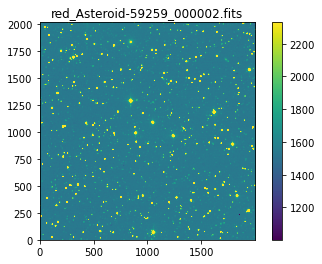

In [64]:
f = newname

ccd = CCDData.read(f, unit = u.adu)

plot_img = ccd
print(plot_img.shape)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
c1 = plt.colorbar(s1)

plt.title(f.split("/")[-1])

plt.show()

In [65]:
len(error_list)

0

In [66]:
# error files?

for f in error_list:
    hdu = fits.open(f)
    print(hdu.info())

In [67]:
for i,f in enumerate(error_list):
        
    hdu = fits.open(f)
    plot_img = hdu[0].data
    print(f,plot_img)
    
    if plot_img is None:
        continue
    
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])
    fig.add_axes(ax1)

    norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
    s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
    c1 = plt.colorbar(s1)

    plt.title(error_list[i].split("/")[-1])

    plt.show()

# plate solve using JPL ephemerides as guess

In [68]:
# files = glob.glob("../Science/**/red*.fits", recursive = True)
df_sci[["frame",'objra','objdec']]

,frame,objra,objdec
2,Asteroid-59259_000001.fits,20:01:58.935,-23:18:12.40
4,Asteroid-59259_000002.fits,20:01:58.935,-23:18:12.40


In [69]:
radius_guess = 0.5 # degrees
# radius_guess = 0.05 # degrees
# radius_guess = None

scale_low = 0.2
scale_high = 0.4

# increase pixel scale when data is binned
if binning=="2x2":
    scale_low *= 2
    scale_high *= 2
    
if radius_guess:
    fname_ast = "astrometry.sh"
else:
    fname_ast = "astrometry_no_guess.sh"
    
with open(fname_ast,"w") as ast_file:

    for i in range(len(df_sci)):
    
        file = df_sci.iloc[i]["file"]
        night = file.split("/")[-2]

        red_file='../Science/{}/red_{}'.format(night,file.split("/")[-1])
        print(red_file)
        if not os.path.isfile(red_file):
            continue
            
#         # solve only for no wcs file
#         if red_file not in no_wcs_red:
#             continue
            
        wcs_file = red_file.split("/")[-1].split(".fits")[0]+"_wcs.fits"
        wcs_file = "/".join(red_file.split("/")[:-1])+"/"+ wcs_file
            
#         if not radius_guess:
        # check if wcs file already exists
        if os.path.isfile(wcs_file):
            continue
        print(wcs_file)

        # initial guess
        print(df_sci.iloc[i][["objra","objdec"]])
        pos = SkyCoord(ra=df_sci.iloc[i]["objra"],dec=df_sci.iloc[i]["objdec"], unit=(u.hourangle, u.degree))
        print(pos)

        ra_guess = pos.ra.deg
        dec_guess = pos.dec.deg
        
        if radius_guess:
            # with guess
            cmd = """solve-field {} -3 {} -4 {} -5 {} --scale-units app --scale-low {} --scale-high {} --new-fits "{}" --objs 40 --dir="Junk/{}" --skip-solved --fits-image --no-plots""".format(
                red_file,ra_guess,dec_guess,radius_guess,scale_low,scale_high,wcs_file,night)
        else:
            # without guess
            cmd = """solve-field {} --scale-units app --scale-low {} --scale-high {} --new-fits "{}" --objs 40 --dir="Junk/{}" --fits-image --no-plots --overwrite""".format(
                red_file,scale_low,scale_high,wcs_file,night)
        
        print(cmd)
    
        ast_file.write("{}\n".format(cmd))
    

../Science/20240601/red_Asteroid-59259_000001.fits
../Science/20240601/red_Asteroid-59259_000002.fits
../Science/20240926/red_Asteroid_29254_000161_wcs.fits
objra     03:07:07.263
objdec    +12:20:21.90
Name: 3011, dtype: object
<SkyCoord (ICRS): (ra, dec) in deg
    (46.7802625, 12.33941667)>
solve-field ../Science/20240926/red_Asteroid_29254_000161.fits -3 46.78026249999999 -4 12.339416666666667 -5 0.5 --scale-units app --scale-low 0.2 --scale-high 0.4 --new-fits "../Science/20240926/red_Asteroid_29254_000161_wcs.fits" --objs 40 --dir="Junk/20240926" --skip-solved --fits-image --no-plots
../Science/20240926/red_Asteroid_29254_000074.fits
../Science/20240926/red_Asteroid_29254_000074_wcs.fits
objra     03:07:08.702
objdec    +12:20:27.83
Name: 3012, dtype: object
<SkyCoord (ICRS): (ra, dec) in deg
    (46.78625833, 12.34106389)>
solve-field ../Science/20240926/red_Asteroid_29254_000074.fits -3 46.78625833333333 -4 12.34106388888889 -5 0.5 --scale-units app --scale-low 0.2 --scale-high

../Science/20240926/red_Asteroid_29254_000119_wcs.fits
objra     03:07:07.573
objdec    +12:20:23.18
Name: 3032, dtype: object
<SkyCoord (ICRS): (ra, dec) in deg
    (46.78155417, 12.33977222)>
solve-field ../Science/20240926/red_Asteroid_29254_000119.fits -3 46.78155416666666 -4 12.339772222222223 -5 0.5 --scale-units app --scale-low 0.2 --scale-high 0.4 --new-fits "../Science/20240926/red_Asteroid_29254_000119_wcs.fits" --objs 40 --dir="Junk/20240926" --skip-solved --fits-image --no-plots
../Science/20240926/red_Asteroid_29254_000125.fits
../Science/20240926/red_Asteroid_29254_000125_wcs.fits
objra     03:07:07.529
objdec    +12:20:23.00
Name: 3033, dtype: object
<SkyCoord (ICRS): (ra, dec) in deg
    (46.78137083, 12.33972222)>
solve-field ../Science/20240926/red_Asteroid_29254_000125.fits -3 46.78137083333333 -4 12.339722222222223 -5 0.5 --scale-units app --scale-low 0.2 --scale-high 0.4 --new-fits "../Science/20240926/red_Asteroid_29254_000125_wcs.fits" --objs 40 --dir="Junk/20240

solve-field ../Science/20240926/red_Asteroid_29254_000043.fits -3 46.78722916666666 -4 12.341336111111112 -5 0.5 --scale-units app --scale-low 0.2 --scale-high 0.4 --new-fits "../Science/20240926/red_Asteroid_29254_000043_wcs.fits" --objs 40 --dir="Junk/20240926" --skip-solved --fits-image --no-plots
../Science/20240926/red_Asteroid_29254_000148.fits
../Science/20240926/red_Asteroid_29254_000148_wcs.fits
objra     03:07:07.359
objdec    +12:20:22.30
Name: 3053, dtype: object
<SkyCoord (ICRS): (ra, dec) in deg
    (46.7806625, 12.33952778)>
solve-field ../Science/20240926/red_Asteroid_29254_000148.fits -3 46.7806625 -4 12.339527777777779 -5 0.5 --scale-units app --scale-low 0.2 --scale-high 0.4 --new-fits "../Science/20240926/red_Asteroid_29254_000148_wcs.fits" --objs 40 --dir="Junk/20240926" --skip-solved --fits-image --no-plots
../Science/20240926/red_Asteroid_29254_000013.fits
../Science/20240926/red_Asteroid_29254_000013_wcs.fits
objra     03:07:09.138
objdec    +12:20:29.66
Name: 3

../Science/20240926/red_Asteroid_29254_000102_wcs.fits
objra     03:07:07.698
objdec    +12:20:23.70
Name: 3086, dtype: object
<SkyCoord (ICRS): (ra, dec) in deg
    (46.782075, 12.33991667)>
solve-field ../Science/20240926/red_Asteroid_29254_000102.fits -3 46.78207499999999 -4 12.339916666666667 -5 0.5 --scale-units app --scale-low 0.2 --scale-high 0.4 --new-fits "../Science/20240926/red_Asteroid_29254_000102_wcs.fits" --objs 40 --dir="Junk/20240926" --skip-solved --fits-image --no-plots
../Science/20240926/red_Asteroid_29254_000014.fits
../Science/20240926/red_Asteroid_29254_000014_wcs.fits
objra     03:07:09.131
objdec    +12:20:29.63
Name: 3087, dtype: object
<SkyCoord (ICRS): (ra, dec) in deg
    (46.78804583, 12.34156389)>
solve-field ../Science/20240926/red_Asteroid_29254_000014.fits -3 46.78804583333333 -4 12.34156388888889 -5 0.5 --scale-units app --scale-low 0.2 --scale-high 0.4 --new-fits "../Science/20240926/red_Asteroid_29254_000014_wcs.fits" --objs 40 --dir="Junk/20240926

../Science/20240926/red_Asteroid_29254_000089_wcs.fits
objra     03:07:07.794
objdec    +12:20:24.10
Name: 3106, dtype: object
<SkyCoord (ICRS): (ra, dec) in deg
    (46.782475, 12.34002778)>
solve-field ../Science/20240926/red_Asteroid_29254_000089.fits -3 46.782475 -4 12.34002777777778 -5 0.5 --scale-units app --scale-low 0.2 --scale-high 0.4 --new-fits "../Science/20240926/red_Asteroid_29254_000089_wcs.fits" --objs 40 --dir="Junk/20240926" --skip-solved --fits-image --no-plots
../Science/20240926/red_Asteroid_29254_000042.fits
../Science/20240926/red_Asteroid_29254_000042_wcs.fits
objra     03:07:08.941
objdec    +12:20:28.84
Name: 3107, dtype: object
<SkyCoord (ICRS): (ra, dec) in deg
    (46.78725417, 12.34134444)>
solve-field ../Science/20240926/red_Asteroid_29254_000042.fits -3 46.78725416666666 -4 12.341344444444445 -5 0.5 --scale-units app --scale-low 0.2 --scale-high 0.4 --new-fits "../Science/20240926/red_Asteroid_29254_000042_wcs.fits" --objs 40 --dir="Junk/20240926" --skip

<SkyCoord (ICRS): (ra, dec) in deg
    (46.7815875, 12.33978333)>
solve-field ../Science/20240926/red_Asteroid_29254_000118.fits -3 46.78158749999999 -4 12.339783333333333 -5 0.5 --scale-units app --scale-low 0.2 --scale-high 0.4 --new-fits "../Science/20240926/red_Asteroid_29254_000118_wcs.fits" --objs 40 --dir="Junk/20240926" --skip-solved --fits-image --no-plots
../Science/20240926/red_Asteroid_29254_000149.fits
../Science/20240926/red_Asteroid_29254_000149_wcs.fits
objra     03:07:07.352
objdec    +12:20:22.27
Name: 3124, dtype: object
<SkyCoord (ICRS): (ra, dec) in deg
    (46.78063333, 12.33951944)>
solve-field ../Science/20240926/red_Asteroid_29254_000149.fits -3 46.78063333333333 -4 12.339519444444445 -5 0.5 --scale-units app --scale-low 0.2 --scale-high 0.4 --new-fits "../Science/20240926/red_Asteroid_29254_000149_wcs.fits" --objs 40 --dir="Junk/20240926" --skip-solved --fits-image --no-plots
../Science/20240926/red_Asteroid_29254_000061.fits
../Science/20240926/red_Asteroid_2

../Science/20240813/red_Asteroid_97176_000036.fits
../Science/20240813/red_Asteroid_10902_000077.fits
../Science/20240813/red_Asteroid_97176_000043.fits
../Science/20240813/red_Asteroid_97176_000047.fits
../Science/20240813/red_Asteroid_10902_000052.fits
../Science/20240813/red_Asteroid_10902_000029.fits
../Science/20240813/red_Asteroid_97176_000039.fits
../Science/20240813/red_Asteroid_10902_000115.fits
../Science/20240813/red_Asteroid_97176_000032.fits
../Science/20240813/red_Asteroid_97176_000012.fits
../Science/20240813/red_Asteroid_97176_000079.fits
../Science/20240813/red_Asteroid_97176_000029.fits
../Science/20240813/red_Asteroid_10902_000017.fits
../Science/20240813/red_Asteroid_10902_000070.fits
../Science/20240813/red_Asteroid_97176_000076.fits
../Science/20240813/red_Asteroid_10902_000045.fits
../Science/20240813/red_Asteroid_97176_000031.fits
../Science/20240813/red_Asteroid_97176_000018.fits
../Science/20240813/red_Asteroid_10902_000056.fits
../Science/20240813/red_Asteroi

In [70]:
# split the astrometry into multiple files on the command line
# split astrometry.sh astrometry -l 250 --additional-suffix=.sh -d
# chmod +x astrometry*

<SkyCoord (ICRS): (ra, dec) in deg
    (300.4955625, -23.30344444)>
<SkyCoord (ICRS): (ra, dec) in deg
    (300.47510883, -23.35505496)>


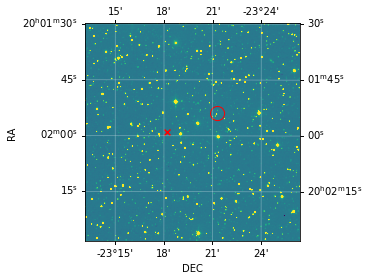

In [71]:
f = wcs_file

hdu = fits.open(f)
data = hdu[0].data
hdr = hdu[0].header
wcs = WCS(hdr)
    
plot_img = data
plot_wcs = wcs
    
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0], projection = plot_wcs)
fig.add_axes(ax1)

norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm, origin='lower')

# plot position of initial guess
_df = df_sci[df_sci["file"].str.contains("/".join(f.split("/")[-2:]).replace("red_","").replace("_wcs",""))]
pos = SkyCoord(ra=_df.iloc[0]["objra"],dec=_df.iloc[0]["objdec"], unit=(u.hourangle, u.degree))
print(pos)
ax1.scatter(pos.ra.degree,pos.dec.degree,c="r",marker="x",
           transform=ax1.get_transform('fk5'))

# # radius_guess = 0.05
# if radius_guess:
#     c = Circle((pos.ra.degree, pos.dec.degree), radius_guess, edgecolor='r', facecolor='none',
#               transform=ax1.get_transform('fk5'))
#     ax1.add_patch(c)
    
# plot reference point from astrometry.net
pos = SkyCoord(ra = hdr["CRVAL1"], dec = hdr["CRVAL2"], unit = (u.degree, u.degree))
print(pos)
ax1.scatter(pos.ra.degree,pos.dec.degree,edgecolor="r", facecolor = "none",
            marker="o",s=200,
           transform=ax1.get_transform('fk5'))

ax1.coords["ra"].set_ticklabel_position('bltr')
ax1.coords["ra"].grid(True, color='white', ls='-', alpha = 0.3)
ax1.coords["dec"].set_ticklabel_position('bltr')
ax1.coords["dec"].grid(True, color='white', ls='-', alpha = 0.3)
ax1.coords[1].set_axislabel('RA')
ax1.coords[0].set_axislabel('DEC')

ax1.coords.grid(True, color='white', ls='-', alpha = 0.3)

plt.show()

In [72]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1998                                                  
NAXIS2  =                 2020                                                  
HISTORY Created with RTS2 version 0.9.4 build on Mar 23 2017 14:45:35.          
CTIME   =           1717316557 / exposure start (seconds since 1.1.1970)        
USEC    =               249583 / exposure start micro seconds                   
JD      =     2460463.84903935 / exposure JD                                    
DATE-OBS= '2024-06-02T08:22:37.249' / start of exposure                         
OBJECT  = 'Asteroid-59259'     / object name                                    
EXPOSURE=                  60. / exposure length in seconds                     
EXPTIME =                  6

In [73]:
# Not all file solved?
#$ cat astrometry.out | grep -B 1 "Did not solve (or no WCS file was written)."
# was the ra dec guess radius large enough?

In [74]:
# find failed files
len(sci_files)

2

In [75]:
no_red = []
no_wcs = []
no_wcs_red = []
red_files = []
wcs_files = []

for i in range(len(df_sci)):

    file = df_sci.iloc[i]["file"]
    night = file.split("/")[-2]

    red_file='../Science/{}/red_{}'.format(night,file.split("/")[-1])
    if not os.path.isfile(red_file):
        no_red.append(file)
    else:
        red_files.append(red_file)

    wcs_file = red_file.split("/")[-1].split(".fits")[0]+"_wcs.fits"
    wcs_file = "/".join(red_file.split("/")[:-1])+"/"+ wcs_file
    if not os.path.isfile(wcs_file):
        no_wcs.append(file)
        no_wcs_red.append(red_file)
    else:
        wcs_files.append(wcs_file)


In [76]:
no_red

[]

In [77]:
no_wcs

[]

In [78]:
len(no_wcs)

0

In [79]:
len(df_sci),len(red_files),len(wcs_files)

(2, 2, 2)

In [80]:
# Plot all no_wcs images
for i,f in enumerate(no_wcs):
    
    if f in no_red:
        continue
        
    hdu = fits.open(f)
    plot_img = hdu[0].data
    
    if plot_img is None:
        print("no data")
        continue
    
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])
    fig.add_axes(ax1)

    norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
    s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
    c1 = plt.colorbar(s1)

#     plt.title(f.split("/")[-1])
    plt.title(f)

    plt.show()
    
#     break